In [137]:
import numpy as np
import matplotlib.pyplot as plt

In [138]:
# Time setup
total_years = 20
dt = 1/10  # yearly time step
time = np.arange(0, total_years, dt)
n = len(time)


# Initialize arrays

Below_Baseline_Stock = np.zeros(n)
Baseline_Stock = np.zeros(n)
Efficient_Stock = np.zeros(n)
Cumulative_adopters = np.zeros(n)


Retirement_Flow_arr = np.zeros(n)
Below_Baseline_Adoption_Flow_arr = np.zeros(n)
Baseline_Adoption_Flow_arr = np.zeros(n)
Efficient_Adoption_Flow_arr = np.zeros(n)
Total_Adoption_Flow_arr = np.zeros(n)
S_new_adopters = np.zeros(n)



In [139]:

""" Could do this from individual pieces to total market size or market size to individual pieces"""
m = 1000  # market size for the equipment # not used in Par
# Initial stocks
initial_below_baseline = m * 0.3  # 30% below baseline
initial_baseline = m * 0.5  # 50% baseline
initial_efficient = m* 0.1  # 10% efficient at start
initial_adopters = initial_efficient

#total_stock = initial_below_baseline + initial_baseline + initial_efficient
# Set initial values

Below_Baseline_Stock[0] = initial_below_baseline
Baseline_Stock[0] = initial_baseline
Efficient_Stock[0] = initial_efficient
Cumulative_adopters[0] = initial_adopters

In [140]:
# Bass diffusion and retirement parameters
par = {
    "p": 0.03,                 # innovation coefficient
    "q": 0.38,                 # imitation coefficient
    "retirement_rate": 0.05    # 5% of total equipment retires per year
}


In [141]:
def bass_diff_eq(Below_Baseline, Baseline, Efficient, Cumulative_adopted, par, m):
    # Parameters
    p = par["p"]               # innovation coefficient
    q = par["q"]               # imitation coefficient
    m = m     # total market size
    retirement_rate = par["retirement_rate"]  # fraction of existing equipment retired per time step

    #Flows
    Retirement_Flow = m * retirement_rate
    # Bass diffusion flow (upgrade adoption)
    S_new_adopters = (p + q * (Cumulative_adopted / m)) * (m - Cumulative_adopted)

    # I am going to say that all the initial stocks loose .05 of population

    Efficient_Adoption_Flow = min(S_new_adopters, Retirement_Flow) - (Efficient*retirement_rate) #either the bass diff number or all available retiring units 
    # Baseline adoption initial loss minus remaining retirement flow
    if S_new_adopters < Retirement_Flow:
        Baseline_Adoption_Flow = (Baseline * retirement_rate) + (Retirement_Flow - S_new_adopters)
    else:
        Baseline_Adoption_Flow = -(Baseline * retirement_rate)

    Below_Baseline_Adoption_Flow = -(Below_Baseline*retirement_rate)
    
    Total_Adoption_Flow = Efficient_Adoption_Flow + Baseline_Adoption_Flow + Below_Baseline_Adoption_Flow

    # Differential changes (Euler step)
    dBelow_Baseline_dt = Below_Baseline_Adoption_Flow
    dBaseline_dt = Baseline_Adoption_Flow
    dEfficient_dt = Efficient_Adoption_Flow
    dadopters_dt = Efficient_Adoption_Flow

    # Flows dictionary
    flows = {
        "Retirement": Retirement_Flow,
        "Efficient_Adoption": Efficient_Adoption_Flow,
        "Baseline_Adoption": Baseline_Adoption_Flow,
        "Below_Baseline_Adoption": Below_Baseline_Adoption_Flow,
        "Total_Adoption_Flow": Total_Adoption_Flow,
        "S_new_adopters": S_new_adopters
    }

    return dBelow_Baseline_dt, dBaseline_dt, dEfficient_dt, dadopters_dt, flows


In [142]:
for t in range(1, n):
    dBelow_Baseline_dt, dBaseline_dt, dEfficient_dt, dadopters_dt,  flows = bass_diff_eq(
        Below_Baseline_Stock[t-1],
        Baseline_Stock[t-1],
        Efficient_Stock[t-1],
        Cumulative_adopters[t-1],
        par,
        m
    )

    # Euler integration
    Below_Baseline_Stock[t] = Below_Baseline_Stock[t-1] + dBelow_Baseline_dt * dt
    Baseline_Stock[t] = Baseline_Stock[t-1] + dBaseline_dt * dt
    Efficient_Stock[t] = Efficient_Stock[t-1] + dEfficient_dt * dt
    Cumulative_adopters[t] = Cumulative_adopters[t-1] + dadopters_dt * dt

#enforce non-negitivity
    Below_Baseline_Stock[t] = max(Below_Baseline_Stock[t], 0.0)
    Baseline_Stock[t]       = max(Baseline_Stock[t], 0.0)
    Efficient_Stock[t]      = max(Efficient_Stock[t], 0.0)
    Cumulative_adopters[t]  = max(Cumulative_adopters[t], 0.0)

    # Log flows
    Retirement_Flow_arr[t] = flows["Retirement"]
    Efficient_Adoption_Flow_arr[t] = flows["Efficient_Adoption"]
    Baseline_Adoption_Flow_arr[t] = flows["Baseline_Adoption"]
    Below_Baseline_Adoption_Flow_arr[t] = flows["Below_Baseline_Adoption"]
    Total_Adoption_Flow_arr[t] = flows["Total_Adoption_Flow"]
    S_new_adopters[t] = flows["S_new_adopters"]


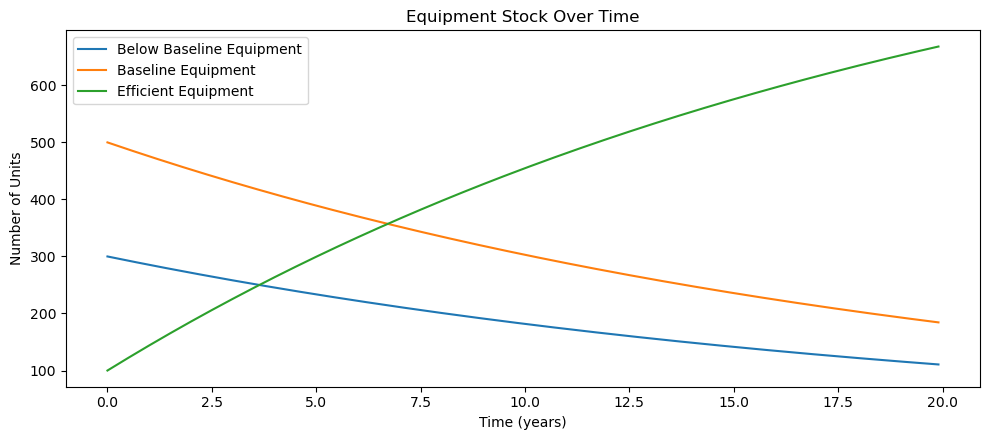

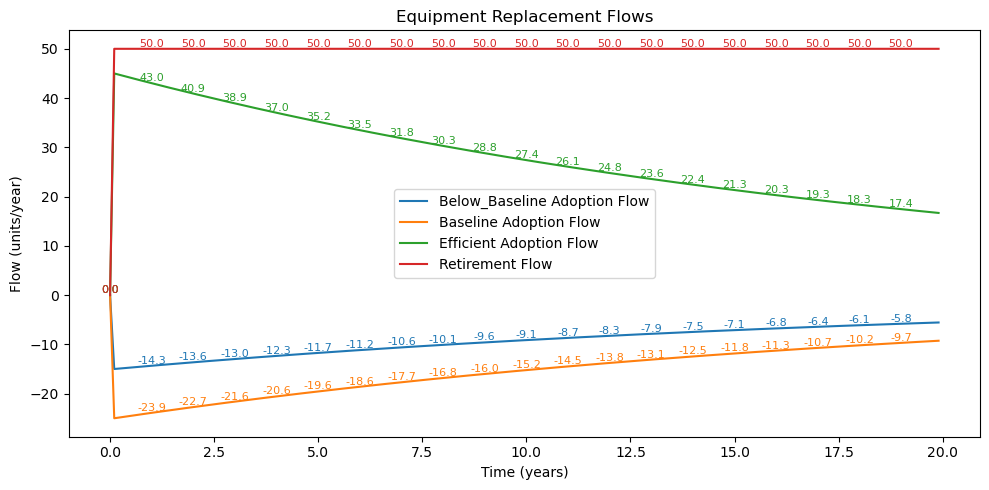

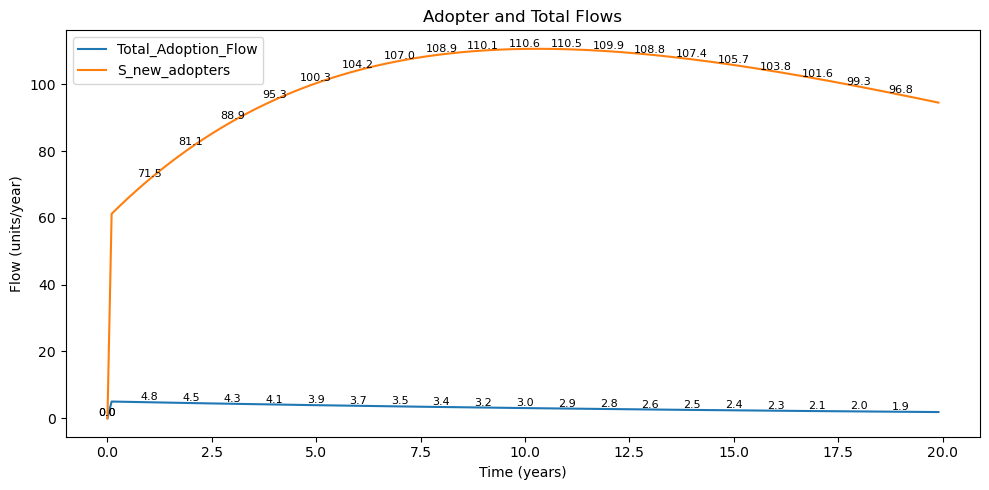

In [143]:
# Equipment Stocks
plt.figure(figsize=(10, 4.5))
plt.plot(time, Below_Baseline_Stock, label="Below Baseline Equipment")
plt.plot(time, Baseline_Stock, label="Baseline Equipment")
plt.plot(time, Efficient_Stock, label="Efficient Equipment")
plt.xlabel("Time (years)")
plt.ylabel("Number of Units")
plt.title("Equipment Stock Over Time")
plt.legend()
plt.tight_layout()
plt.show()

# Equipment Flows
plt.figure(figsize=(10, 5))
plt.plot(time, Below_Baseline_Adoption_Flow_arr, label="Below_Baseline Adoption Flow")
plt.plot(time, Baseline_Adoption_Flow_arr, label="Baseline Adoption Flow")
plt.plot(time, Efficient_Adoption_Flow_arr, label="Efficient Adoption Flow")
plt.plot(time, Retirement_Flow_arr, label="Retirement Flow")

for i in range(0, len(time), 10):
    plt.text(time[i], Below_Baseline_Adoption_Flow_arr[i], f"{Below_Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], Baseline_Adoption_Flow_arr[i], f"{Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], Efficient_Adoption_Flow_arr[i], f"{Efficient_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:green')
    plt.text(time[i], Retirement_Flow_arr[i], f"{Retirement_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:red')

plt.xlabel("Time (years)")
plt.ylabel("Flow (units/year)")
plt.title("Equipment Replacement Flows")
plt.legend()
plt.tight_layout()
plt.show()

# Adopters
plt.figure(figsize=(10, 5))
plt.plot(time, Total_Adoption_Flow_arr, label="Total_Adoption_Flow")

# Add Y-value labels every 10th point
for i in range(0, len(time), 10):
    plt.text(time[i], Total_Adoption_Flow_arr[i], f"{Total_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom')
plt.plot(time, S_new_adopters, label="S_new_adopters")

# Add Y-value labels every 10th point
for i in range(0, len(time), 10):
    plt.text(time[i], S_new_adopters[i], f"{S_new_adopters[i]:.1f}", 
             fontsize=8, ha='center', va='bottom')
plt.xlabel("Time (years)")
plt.ylabel("Flow (units/year)")
plt.title("Adopter and Total Flows")
plt.legend()
plt.tight_layout()
plt.show()